In [1]:
#Odwrócić kolejność predykcji w LSTM
#Użyć jako wejścia dla każdego elementu dekodera ukrytego stanu

In [13]:
import numpy as np
import torch
import torch.nn as nn
import pickle
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

In [14]:
with open("../Dane/Datasets/d20.pickle", "rb") as file:
    dataset=pickle.load(file)

dataset=[torch.Tensor(ar).reshape(-1,1) for ar in dataset]

In [6]:
class Siec(nn.Module):
    def __init__(self, hidden_size, layers=1):
        super().__init__()
        self.lstmEncoder=nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=layers)
        self.lstmDecoder=nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=layers)
        self.linear=nn.Linear(in_features=hidden_size, out_features=1)
        self.relu=nn.ReLU()
        
        for n,p in self.lstmEncoder.named_parameters():
            if "weight_hh" in n:
                nn.init.orthogonal_(p)
        for n,p in self.lstmDecoder.named_parameters():
            if "weight_hh" in n:
                nn.init.orthogonal_(p)
        #nn.init.ones_(self.lstm.bias_ih_l0)
        
    def forward(self, X):
        _,(H,C)=self.lstmEncoder(X)
        C.zero_()
        A,L=nn.utils.rnn.pad_packed_sequence(X)
        A.zero_()
        wejscie=nn.utils.rnn.pack_padded_sequence(A,L, enforce_sorted=False)
        X,_=self.lstmDecoder(wejscie,(H,C))
        X,_=nn.utils.rnn.pad_packed_sequence(X)
        X=self.linear(X)
        return X

In [7]:
def uczModel(model, dataset, validationset, batch_size=128, ifCuda=True, lr=1e-3, epoch_count=30,
            log_every=50, mnoznikKaryZaKopie=20, przesuniecie=7, offset=10, 
             podzialyDatasetu=[(1/20)*(i+1) for i in range(20)]):
    def evalBatch(batch):
        X=nn.utils.rnn.pack_sequence(batch, enforce_sorted=False)
        if ifCuda:
            X=X.to("cuda")
        result=model(X)
        X=nn.utils.rnn.pad_sequence(batch)
        if ifCuda:
            X=X.to("cuda")
        diffrenceWithNext=(result-X)**2
        #diffrenceWithNext=(result[offset:-przesuniecie,:,:]-X[przesuniecie+offset:,:,:])**2
        #diffrenceWithCopy=(result[offset:-przesuniecie,:,:]-X[offset:-przesuniecie,:,:])**2
        #diffrenceWithNext[diffrenceWithCopy<diffrenceWithNext]*=mnoznikKaryZaKopie;
        score=torch.sum(diffrenceWithNext)#+torch.sum(model.relu(diffrenceWithNext-diffrenceWithCopy))*mnoznikKaryZaKopie
        return score
    
    validationset.sort(key=lambda x:len(x))
    dataset.sort(key=lambda x:len(x))
    
    if ifCuda:
        model=model.to("cuda")
    
    data_validation=torch.utils.data.DataLoader(validationset,batch_size=batch_size, collate_fn=lambda x : x)
    bestAvgValidationScore=np.inf
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    iter_counter=0
    
    try:    
        for podzial in podzialyDatasetu:
            data_train=torch.utils.data.DataLoader(dataset[:int(len(dataset)*podzial)],
                                                   batch_size=batch_size, 
                                                   collate_fn=lambda x : x, shuffle=True)
            for epoch in range(epoch_count):
                #Training
                for batch in data_train:
                    iter_counter+=1
                    optimizer.zero_grad()
                    score=evalBatch(batch)
                    score.backward()
                    optimizer.step()
                    if iter_counter % log_every == 0:
                        print("Minibatch {0: >6}  | avg. loss {1: >9.7f}".format(
                            iter_counter,score.item()/batch_size))
                #Validation
                validationScore=0
                with torch.no_grad():
                    for batch in data_validation:
                        validationScore+=evalBatch(batch)
                avgValidationScore=validationScore/len(validationset)

                if avgValidationScore < bestAvgValidationScore:
                    best_epoch = epoch
                    bestAvgValidationScore=avgValidationScore
                    best_params = [p.detach().cpu() for p in model.parameters()]
                clear_output(True)
                m = "After epoch {0: >2} | valid score: {1: >9.7f} | best valid score: {2: >9.7f} | best epoch {3: >3} | podzial: {4: >3.2}".format(
                    epoch, avgValidationScore, bestAvgValidationScore, best_epoch, podzial
                )
                print("{0}\n{1}\n{0}".format("-" * len(m), m))
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param       

In [8]:
model=Siec(64, layers=1)

In [10]:
len(dataset)

60372

In [11]:
podzial=59000
W=uczModel(model, dataset[:podzial],dataset[-podzial:], batch_size=256, log_every=20, lr=0.001, epoch_count=10,
          mnoznikKaryZaKopie=1000, przesuniecie=1, offset=0)

------------------------------------------------------------------------------------------------------
After epoch  2 | valid score: 0.1121569 | best valid score: 0.1032291 | best epoch   1 | podzial: 0.05
------------------------------------------------------------------------------------------------------
Minibatch     40  | avg. loss 0.0447755

Loading best params on validation set (epoch 1)



In [11]:
szereg=dataset[-2:]
szeregPacked=nn.utils.rnn.pack_sequence(szereg, enforce_sorted=False).to("cuda")

In [12]:
X=model(szeregPacked)

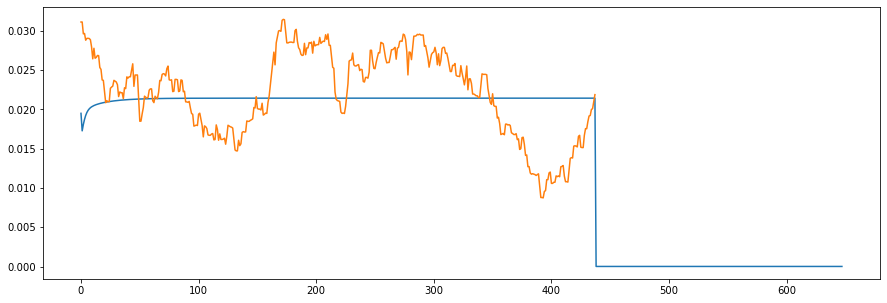

In [16]:
plt.gcf().set_size_inches((15,5))
#plt.xlim((200,300))
plt.plot(np.array(X[:,1,0].cpu().detach()))
plt.plot(np.array(szereg[1][:]))

In [17]:
X.shape

torch.Size([648, 2, 1])

In [20]:
szereg[0].shape

torch.Size([648, 1])

In [21]:
np.sum((np.array(X[:,0,0].cpu().detach())-np.array(szereg[0]).ravel())**2)

0.028372977

In [12]:
np.sum((np.array(X[:-1,1,0].cpu().detach())-np.array(szereg[1][1:]).ravel())**2)

0.47306597

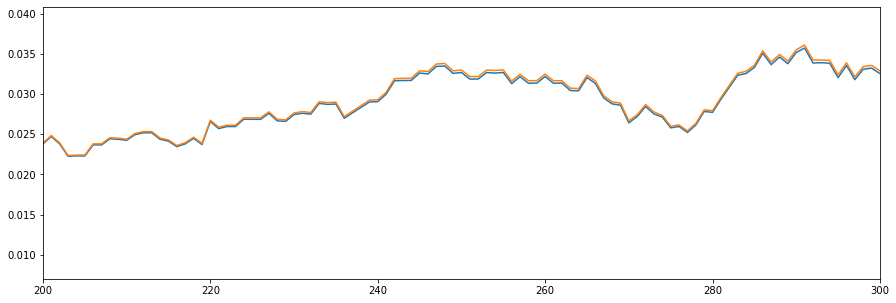

In [42]:
plt.gcf().set_size_inches((15,5))
plt.xlim((200,300))
plt.plot(np.array(X[:,0,0].cpu().detach()))
plt.plot(np.array(szereg[0]))

In [51]:
np.sum((np.array(X[:,0,0].cpu().detach())-np.array(szereg[0]).ravel())**2)

2.3230652e-05

In [52]:
np.sum((np.array(X[:-1,0,0].cpu().detach())-np.array(szereg[0][1:]).ravel())**2)

0.00052029593